In [143]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [144]:
round6_tires = {"hoosier_LCO_18.0x6.0_10x6":{"long":None, "lat":None},
"hoosier_LCO_18.0x6.0_10x7":{"long":None, "lat":None},
"hoosier_r25b_18.0x6.0_10x7":{"long":None, "lat":None},
"hoosier_r25b_18.0x7.5_10x7":{"long":None, "lat":None},
"hoosier_r25b_18.0x7.5_10x8":{"long":None, "lat":None}}

camber = 0 # default camber
pressure = 12 * 6.89476 # default pressure
velocity = 25 * 1.60934 # default velocity
slip_angle = 0
slip_ratio = 0
run_num = 1
normalized_CS = True

In [145]:
for name, tire in round6_tires.items():
    try:
        df = pd.read_csv(f"../tire_data/processed_data/Round6_10in/braking_{name}.csv")
        tire["long"] = df[(df["pressure"] == pressure) & (df["velocity"] == velocity) & (df["slip"] == slip_angle) & (df["camber"] == camber)]
        # & (df["SL"] < slip_ratio + 0.25) & (df["SL"] > slip_ratio - 0.25)
        # print(tire["long"])
        
    except:
        print("Error getting long data for {0}".format(name))

    try:
        df = pd.read_csv(f"../tire_data/processed_data/Round6_10in/cornering_{name}.csv")
        tire["lat"] = df[(df["velocity"] == velocity) & (df["pressure"] == pressure) & (df["SR"] < 0.075) & (df["SR"] > -0.075) & (df["camber"] == camber)]
        # print(tire["lat"])

    except:
        print("Error getting lateral data for {0}".format(name))

In [146]:
def cornering_stiffness(lat_df):
    filtered_data = [x for x in lat_df["SA"].unique() if abs(x) < 0.1]
    filtered_data.sort()
    max_SA = filtered_data[-1]
    min_SA = filtered_data[0]

    max_FY = lat_df[lat_df["SA"] == max_SA]["FY"]
    min_FY = lat_df[lat_df["SA"] == min_SA]["FY"]

    return abs((max(max_FY) - max(min_FY)) / (max_SA - min_SA))


In [147]:
lat_long = "lat"

tire_matrix = []

for tire in round6_tires:
    tire_matrix.append(round6_tires[tire][f"{lat_long}"])

In [148]:
load_classification_matrix = [[] for x in range(len(tire_matrix))]

for tire_data in tire_matrix:
    loads = np.array(tire_data["load"].unique())
    for i in range(len(loads)):
        load_classification_matrix[i].append(tire_data[tire_data["load"] == loads[i]])


In [149]:
cornering_stiffness_matrix = [[] for x in range(len(load_classification_matrix))]

if normalized_CS:
    j = -1
    for tire in load_classification_matrix:
        j += 1
        for i in range(len(tire)):
            cornering_stiffness_matrix[j].append(cornering_stiffness(tire[i]) / max(tire[i]["load"]) * -1)

else:
    j = -1
    for tire in load_classification_matrix:
        j += 1
        for i in range(len(tire)):
            cornering_stiffness_matrix[j].append(cornering_stiffness(tire[i]) * -1)

Text(0, 0.5, 'Normalized Cornering Stiffness (deg^-1)')

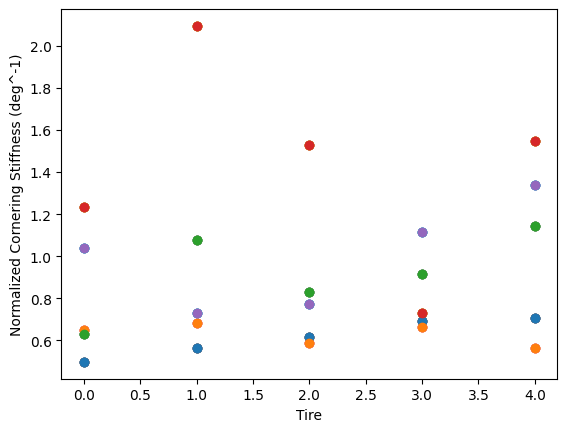

In [151]:
for i in range(len(cornering_stiffness_matrix)):
    for j in range(len(cornering_stiffness_matrix[0])):
        plt.scatter([x for x in range(len(cornering_stiffness_matrix))], cornering_stiffness_matrix[j])

plt.xlabel("Tire")
plt.ylabel("Normalized Cornering Stiffness (deg^-1)")